### Import Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import glob
from glob import glob

import numpy as np
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
!unzip /content/drive/MyDrive/cs284/archive.zip

Archive:  /content/drive/MyDrive/cs284/archive.zip
  inflating: Dataset_BUSI_with_GT/benign/benign (1).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (1)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (10).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (10)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (100).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (100)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (100)_mask_1.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (101).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (101)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (102).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (102)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (103).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (103)_mask.png  
  inflating: Dataset_BUSI_with_GT/benign/benign (104).png  
  inflating: Dataset_BUSI_with_GT/benign/benign (104)_mask.png  
  inflating: 

### Explore Data of Each Classes

In [ ]:
paths = glob('/content/Dataset_BUSI_with_GT/*/*')

print(f"'normal' class has {len([i for i in paths if 'normal' in i and 'mask' not in i])} images and {len([i for i in paths if 'normal' in i and 'mask' in i])} masks.")
print(f"'benign' class has {len([i for i in paths if 'benign' in i and 'mask' not in i])} images and {len([i for i in paths if 'benign' in i and 'mask' in i])} masks.")
print(f"'malignant' class has {len([i for i in paths if 'malignant' in i and 'mask' not in i])} images and {len([i for i in paths if 'malignant' in i and 'mask' in i])} masks.")
print(f"\nThere are total of {len([i for i in paths if 'mask' not in i])} images and {len([i for i in paths if 'mask' in i])} masks.")

'normal' class has 133 images and 133 masks.
'benign' class has 437 images and 454 masks.
'malignant' class has 210 images and 211 masks.

There are total of 780 images and 798 masks.


Loading and preprocess dataset of images (and potentially multiple masks per image).
The preprocessing steps include
* grayscale conversion,
* normalization

In [ ]:
def load_image(path, size):
    image = cv2.imread(path)
    image = cv2.resize(image, (size,size))
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)   # shape: (size,size,3) -> (size,size,1)
    image = image/255.   # normalize
    return image

def load_data(root_path, size):
    images = []
    masks = []

    x = 0   # additional variable to identify images consisting of 2 or more masks

    for path in sorted(glob(root_path)):
        img = load_image(path, size)   # read mask or image

        if 'mask' in path:
            if x:   # this image has masks more than one
                masks[-1] += img   # add the mask to the last mask

                # When 2 masks are added, the range can increase by 0-2. So we will reduce it again to the range 0-1.
                masks[-1] = np.array(masks[-1]>0.5, dtype='float64')
            else:
                masks.append(img)
                x = 1   # if the image has a mask again, the above code will run next time
        else:
            images.append(img)
            x = 0   # for moving to the next image
    return np.array(images), np.array(masks)

In [ ]:
img_size = 500   # image size: 500 * 500
X_image, X_mask = load_data('/content/Dataset_BUSI_with_GT/*/*', img_size)
X_image.shape

(780, 500, 500)

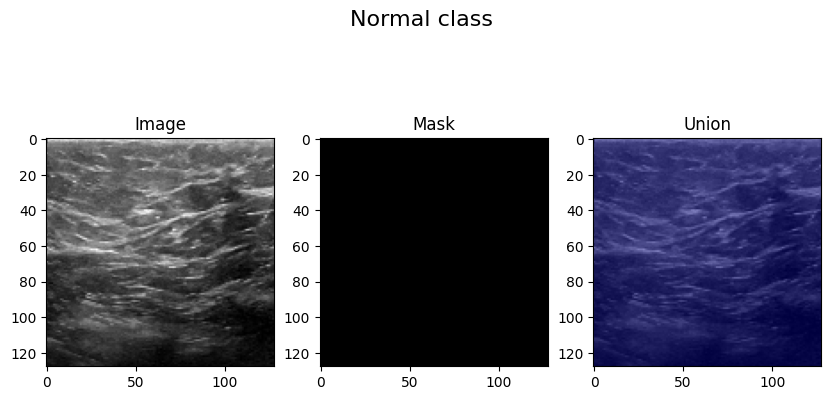

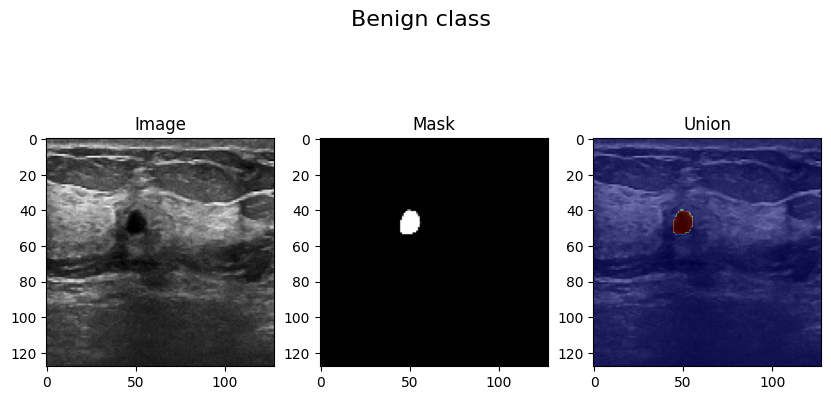

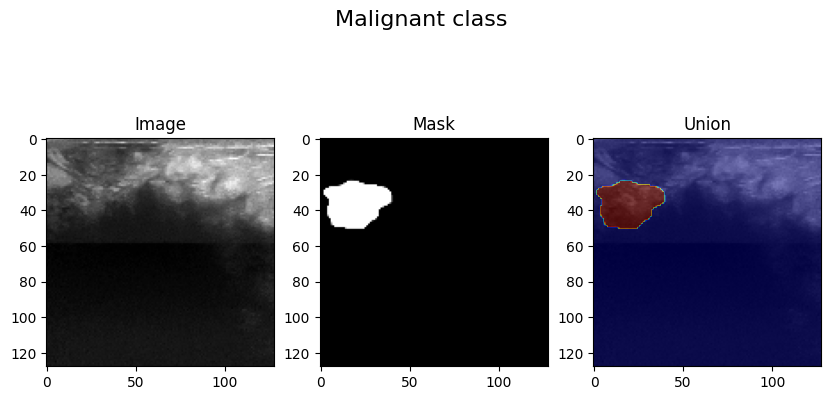

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(10,5))

i = np.random.randint(647,780)
ax[0].imshow(X_image[i], cmap='gray')
ax[0].set_title('Image')
ax[1].imshow(X_mask[i], cmap='gray')
ax[1].set_title('Mask')
ax[2].imshow(X_image[i], cmap='gray')
ax[2].imshow(tf.squeeze(X_mask[i]), alpha=0.5, cmap='jet')
ax[2].set_title('Union')
fig.suptitle('Normal class', fontsize=16)
plt.show()

fig, ax = plt.subplots(1,3, figsize=(10,5))

i = np.random.randint(437)
ax[0].imshow(X_image[i], cmap='gray')
ax[0].set_title('Image')
ax[1].imshow(X_mask[i], cmap='gray')
ax[1].set_title('Mask')
ax[2].imshow(X_image[i], cmap='gray')
ax[2].imshow(tf.squeeze(X_mask[i]), alpha=0.5, cmap='jet')
ax[2].set_title('Union')
fig.suptitle('Benign class', fontsize=16)
plt.show()

fig, ax = plt.subplots(1,3, figsize=(10,5))

i = np.random.randint(437,647)
ax[0].imshow(X_image[i], cmap='gray')
ax[0].set_title('Image')
ax[1].imshow(X_mask[i], cmap='gray')
ax[1].set_title('Mask')
ax[2].imshow(X_image[i], cmap='gray')
ax[2].imshow(tf.squeeze(X_mask[i]), alpha=0.5, cmap='jet')
ax[2].set_title('Union')
fig.suptitle('Malignant class', fontsize=16)
plt.show()

### Data Split and Augmentation

In [ ]:
X = np.array(list(zip(X_image, X_mask)))
X.shape

(780, 2, 500, 500)

In [ ]:
from sklearn.model_selection import train_test_split

# X[0:437] benign
# X[437:647] malignant
# X[647:780] normal
y = np.array([0]*437 + [1]*210 + [2]*133)

# add labels to ensure a stratified split, which maintains the proportion of each class across splits.
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)


In [ ]:
# convert splits into image and masks
X_train, mask_train = zip(*X_train)
X_train, mask_train = np.array(X_train), np.array(mask_train)
X_val, mask_val = zip(*X_val)
X_val, mask_val = np.array(X_val), np.array(mask_val)
X_test, mask_test = zip(*X_test)
X_test, mask_test = np.array(X_test), np.array(mask_test)

In [ ]:
# expand dims
X_train, mask_train = np.expand_dims(X_train, -1), np.expand_dims(mask_train, -1)
X_val, mask_val = np.expand_dims(X_val, -1), np.expand_dims(mask_val, -1)
X_test, mask_test = np.expand_dims(X_test, -1), np.expand_dims(mask_test, -1)

In [ ]:
print(X_train.shape, mask_train.shape, y_train.shape)
print(X_val.shape, mask_val.shape, y_val.shape)
print(X_test.shape, mask_test.shape, y_test.shape)

(624, 500, 500, 1) (624, 500, 500, 1) (624,)
(78, 500, 500, 1) (78, 500, 500, 1) (78,)
(78, 500, 500, 1) (78, 500, 500, 1) (78,)


In [ ]:
# data augmentation for training data
data_gen_args = dict(rotation_range=10,
                     width_shift_range=0.05,
                     height_shift_range=0.05,
                     shear_range=0.05,
                     zoom_range=0.05,
                     horizontal_flip=True,
                     fill_mode='nearest',)
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

In [ ]:
seed = 42
augment = True
def augment_data(X_data, M_data, labels, batch_size):

    # Create two separate generators for images and masks
    # same seed and shuffle settings helps to maintain the alignment between each image and its corresponding mask.
    image_gen = image_datagen.flow(X_data, labels, batch_size=batch_size, seed=seed, shuffle=True)
    mask_gen = mask_datagen.flow(M_data, labels, batch_size=batch_size, seed=seed, shuffle=True)

    while True:
        X1i, labels1 = image_gen.next()
        X2i, _ = mask_gen.next()
        yield X1i, X2i, labels1

In [ ]:
batch_size = 6
num_of_augmentations = 1872  # 3 times of the training data
augmented_images, augmented_masks, augmented_labels = [], [], []

# Create augmented data
augment_gen = augment_data(X_train, mask_train, y_train, batch_size)

for i in range(num_of_augmentations // batch_size):
    img_batch, mask_batch, label_batch = next(augment_gen)
    augmented_images.extend(img_batch)
    augmented_masks.extend(mask_batch)
    augmented_labels.extend(label_batch)

# Convert lists to numpy arrays
augmented_images = np.array(augmented_images)
augmented_masks = np.array(augmented_masks)
augmented_labels = np.array(augmented_labels)

In [ ]:
np.savez_compressed('val_data.npz', images=X_val, labels=y_val, masks=mask_val)
np.savez_compressed('test_data.npz', images=X_test, labels=y_test, masks=mask_test)

In [ ]:
# Save the augmented data
np.savez_compressed('train_data.npz', images=augmented_images, masks=augmented_masks, labels=augmented_labels)
print(augmented_images.shape, augmented_masks.shape, augmented_labels.shape)

(1872, 500, 500, 1) (1872, 500, 500, 1) (1872,)


### Load data

As part of our project, we have a total of 780 ultrasound images. The dataset was divided into training, validation, and testing sets with an 8:1:1 split, resulting in approximately 624 training images, and 78 images each for validation and testing. After applying data augmentation techniques to the training set, we have expanded it to 1824 samples.

Each image in our dataset, including augmented ones, has dimensions of 500 x 500 pixels. For guidance on how to load and utilize this data, please refer to the example provided below.

For classification tasks, we use the images (X_<dataset>), masks (masks_<dataset>), and labels (y_<dataset>). In contrast, for segmentation tasks, we primarily focus on the images and masks.

We have converted all images from RGB to grayscale, reducing the last dimension of our data from 3 (for RGB) to 1 (for grayscale). This decision was driven by two main factors: the limited RAM available in common Google Colab instances and the nature of ultrasound imaging. Ultrasound images are typically related to texture and intensity variations, which are well-represented in grayscale.
Converting these images to grayscale ensures that the data is in a form that is most natural and relevant for analysis, also simplify the computational requirements for processing the images, making algorithms faster and reducing the amount of data that needs to be handled.

In [ ]:
train_data, val_data, test_data = np.load('train_data.npz'), np.load('val_data.npz'), np.load('test_data.npz')

# get the image, mask and labels
X_train, masks_train, y_train = train_data['images'], train_data['masks'], train_data['labels']
X_val, masks_val, y_val = val_data['images'], val_data['masks'], val_data['labels']
X_test, masks_test, y_test = test_data['images'], test_data['masks'], test_data['labels']

In [ ]:
print(X_train.shape, masks_train.shape, y_train.shape)
print(X_val.shape, masks_val.shape, y_val.shape)
print(X_test.shape, masks_test.shape, y_test.shape)

(1872, 500, 500, 1) (1872, 500, 500, 1) (1872,)
(78, 500, 500, 1) (78, 500, 500, 1) (78,)
(78, 500, 500, 1) (78, 500, 500, 1) (78,)
